In [1]:
from common import colors, pvalue_thresholds, sbarlw, savefig

In [2]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [3]:
import warnings
import re
import copy
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.interpolate import griddata
from tqdm import tqdm, trange

from ezephys import pltools
from statannot import add_stat_annotation

from grr.Simulation import GIFnet_Simulation
from grr.GainEstimator import GainEstimator
from grr.Tools import raiseExpectedGot, timeToIndex, reprint
from grr.Spiketrain import PSTH
from grr.CurveFit import plot_linear_fit

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')

In [5]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network', 'deriv_input_dv_adaptation_swap_ser_only')

sim_dict = {'Baseline level': [], 'Rep': [], 'Model': []}

for baseline_level in ['-0.080', '-0.060', '-0.040', '-0.020', '0.000', '0.020', '0.040', '0.060', '0.080']:
    for fname in os.listdir(os.path.join(DATA_PATH, '{}_baseline'.format(baseline_level))):
        if fname.endswith(('hdf5', 'h5')):

            try:
                sim_dict['Model'].append(
                    GIFnet_Simulation(
                        os.path.join(DATA_PATH, '{}_baseline'.format(baseline_level), fname), 
                        mode = 'r'
                    )
                )
                sim_dict['Baseline level'].append(float(baseline_level))
                sim_dict['Rep'].append(
                    int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                )
            except IOError:
                print('Problem with {} baseline {}'.format(baseline_level, fname))
                continue
            

sim_df = pd.DataFrame(sim_dict).sort_values(['Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Baseline level,Model,Rep
0,-0.02,"[connectivity_matrix, gaba, ser]",0
1,-0.06,"[connectivity_matrix, gaba, ser]",0
2,-0.08,"[connectivity_matrix, gaba, ser]",0
3,0.06,"[connectivity_matrix, gaba, ser]",0
4,0.00,"[connectivity_matrix, gaba, ser]",0


In [6]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [7]:
PSTH_width = 50.

for i in trange(sim_df.shape[0], desc='Model'):
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in trange(sim_df.loc[i, 'Model'].get_no_sweeps(), desc='5HT sweep', leave=False):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    sim_df.at[i, 'GABA PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in trange(sim_df.loc[i, 'Model'].get_no_sweeps(), desc='GABA sweep', leave=False):
        sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_gaba_neurons()
        )

print('\nDone!')

5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                                                          
Model:   2%|▏         | 3/180 [00:31<30:40, 10.40s/it]     


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.56it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s]
                                                          
Model:   3%|▎         | 6/180 [00:59<28:28,  9.82s/it]     


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.98it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]
                                                          
Model:   5%|▌         | 9/180 [01:27<26:52,  9.43s/it]     


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]
                                                          
Model:   7%|▋         | 12/180 [01:54<25:49,  9.22s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.67it/s]
                                                          
Model:   8%|▊         | 15/180 [02:24<26:08,  9.51s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.59it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:06<00:00,  3.44it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                                                          
Model:  10%|█         | 18/180 [02:54<26:36,  9.85s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]
                                                          
Model:  12%|█▏        | 21/180 [03:23<25:56,  9.79s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.65it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]
                                                          
Model:  13%|█▎        | 24/180 [03:51<24:55,  9.58s/it]    


5HT sweep: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]
                                                          
Model:  15%|█▌        | 27/180 [04:21<24:37,  9.66s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.76it/s]
                                                          
Model:  17%|█▋        | 30/180 [04:49<23:48,  9.52s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.43it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]
                                                          
Model:  18%|█▊        | 33/180 [05:18<23:30,  9.60s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.30it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]
                                                          
Model:  20%|██        | 36/180 [05:48<23:36,  9.84s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]
                                                          
Model:  22%|██▏       | 39/180 [06:16<22:36,  9.62s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.68it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.27it/s]
                                                          
Model:  23%|██▎       | 42/180 [06:46<22:32,  9.80s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.82it/s]
                                                          
Model:  25%|██▌       | 45/180 [07:15<21:41,  9.64s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]
                                                          
Model:  27%|██▋       | 48/180 [07:44<21:26,  9.75s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
                                                          
Model:  28%|██▊       | 51/180 [08:09<18:54,  8.79s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.59it/s]
                                                          
Model:  30%|███       | 54/180 [08:38<19:41,  9.38s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]
                                                          
Model:  32%|███▏      | 57/180 [09:07<19:34,  9.55s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.39it/s]
                                                          
Model:  33%|███▎      | 60/180 [09:36<19:33,  9.78s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.98it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.67it/s]
                                                          
Model:  35%|███▌      | 63/180 [10:05<18:43,  9.60s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]
                                                          
Model:  37%|███▋      | 66/180 [10:34<18:28,  9.72s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.84it/s]
                                                          
Model:  38%|███▊      | 69/180 [11:03<17:37,  9.53s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.71it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.24it/s]
                                                          
Model:  40%|████      | 72/180 [11:31<17:08,  9.52s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.56it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
                                                          
Model:  42%|████▏     | 75/180 [12:01<17:13,  9.84s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.73it/s]
                                                          
Model:  43%|████▎     | 78/180 [12:30<16:30,  9.71s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]
                                                          
Model:  45%|████▌     | 81/180 [12:58<15:36,  9.46s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]
                                                          
Model:  47%|████▋     | 84/180 [13:26<14:54,  9.32s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.73it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.56it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
                                                          
Model:  48%|████▊     | 87/180 [13:55<14:54,  9.61s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]
                                                          
Model:  50%|█████     | 90/180 [14:25<14:42,  9.81s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  4.00it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.56it/s]
                                                          
Model:  52%|█████▏    | 93/180 [14:53<13:59,  9.65s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.95it/s]
                                                          
Model:  53%|█████▎    | 96/180 [15:21<13:09,  9.40s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]
                                                          
Model:  55%|█████▌    | 99/180 [15:50<12:58,  9.61s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.84it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                                                          
Model:  57%|█████▋    | 102/180 [16:19<12:29,  9.61s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.65it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]
                                                          
Model:  58%|█████▊    | 105/180 [16:47<11:37,  9.29s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]
                                                          
Model:  60%|██████    | 108/180 [17:16<11:38,  9.70s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:06<00:00,  3.45it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]
                                                          
Model:  62%|██████▏   | 111/180 [17:46<11:09,  9.70s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.72it/s]
                                                          
Model:  63%|██████▎   | 114/180 [18:14<10:26,  9.49s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.89it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]
                                                          
Model:  65%|██████▌   | 117/180 [18:43<10:06,  9.62s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.94it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]
                                                          
Model:  67%|██████▋   | 120/180 [19:11<09:20,  9.35s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.67it/s]
                                                          
Model:  68%|██████▊   | 123/180 [19:40<09:05,  9.57s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.20it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]
                                                          
Model:  70%|███████   | 126/180 [20:09<08:46,  9.74s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                                                          
Model:  72%|███████▏  | 129/180 [20:39<08:14,  9.69s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]
                                                          
Model:  73%|███████▎  | 132/180 [21:08<07:46,  9.73s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]
                                                          
Model:  75%|███████▌  | 135/180 [21:36<07:01,  9.37s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.59it/s]
                                                          
Model:  77%|███████▋  | 138/180 [22:05<06:45,  9.65s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]
                                                          
Model:  78%|███████▊  | 141/180 [22:33<06:08,  9.45s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.40it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
                                                          
Model:  80%|████████  | 144/180 [23:02<05:43,  9.53s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]
                                                          
Model:  82%|████████▏ | 147/180 [23:31<05:18,  9.65s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]
                                                          
Model:  83%|████████▎ | 150/180 [24:00<04:49,  9.66s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.83it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                                                          
Model:  85%|████████▌ | 153/180 [24:29<04:22,  9.73s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                                                          
Model:  87%|████████▋ | 156/180 [24:58<03:53,  9.74s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.43it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.76it/s]
                                                          
Model:  88%|████████▊ | 159/180 [25:27<03:23,  9.69s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.27it/s]
                                                          
Model:  90%|█████████ | 162/180 [25:56<02:57,  9.85s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.88it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.41it/s]
                                                          
Model:  92%|█████████▏| 165/180 [26:25<02:25,  9.68s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:06<00:00,  3.50it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
                                                          
Model:  93%|█████████▎| 168/180 [26:54<01:56,  9.69s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.43it/s]
                                                          
Model:  95%|█████████▌| 171/180 [27:24<01:28,  9.84s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.71it/s]
                                                          
Model:  97%|█████████▋| 174/180 [27:52<00:57,  9.61s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.59it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                                                          
Model:  98%|█████████▊| 177/180 [28:22<00:29,  9.78s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.43it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.88it/s]
                                                          
Model: 100%|██████████| 180/180 [28:51<00:00,  9.62s/it]   


Done!


In [8]:
sim_df.head()

,Baseline level,Model,Rep,Principal PSTH,GABA PSTH
0,-0.02,"[connectivity_matrix, gaba, ser]",0,"[[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.933333333333...","[[0.8500000000000001, 0.8500000000000001, 0.85..."
1,-0.06,"[connectivity_matrix, gaba, ser]",0,"[[1.3333333333333335, 1.3333333333333335, 1.33...","[[0.30000000000000004, 0.30000000000000004, 0...."
2,-0.08,"[connectivity_matrix, gaba, ser]",0,"[[1.2333333333333334, 1.2333333333333334, 1.23...","[[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0...."
3,0.06,"[connectivity_matrix, gaba, ser]",0,"[[7.933333333333334, 7.933333333333334, 8.0333...","[[11.55, 11.55, 11.55, 11.55, 11.6000000000000..."
4,0.00,"[connectivity_matrix, gaba, ser]",0,"[[2.9000000000000004, 2.9000000000000004, 2.90...","[[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,..."


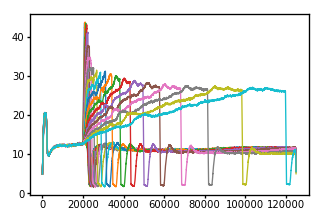

In [9]:
psths = []
for i, row in sim_df.loc[sim_df['Baseline level'] == 0.040, ['Rep', 'Principal PSTH', 'GABA PSTH']].iterrows():
    psths.append(row['Principal PSTH'].T)
    
psths = np.array(psths)

plt.plot(psths.mean(axis=0))

In [10]:
BASELINE_LEVELS = np.array([-0.080, -0.060, -0.040, -0.020, 0, 0.020, 0.040, 0.060, 0.080])

max_resp = {key: np.empty((20, len(BASELINE_LEVELS))) for key in ['ser', 'som']}
max_resp_std = {key: np.empty((20, len(BASELINE_LEVELS))) for key in ['ser', 'som']}
for i, baseline in enumerate(BASELINE_LEVELS):

    psths = {key: [] for key in max_resp.keys()}
    for j, row in sim_df.loc[sim_df['Baseline level'] == baseline, ['Rep', 'Principal PSTH', 'GABA PSTH']].iterrows():
        psths['ser'].append(row['Principal PSTH'])
        psths['som'].append(row['GABA PSTH'])

    for key in max_resp:
        max_resp[key][:, i] = np.asarray(psths[key])[:, :, 19000:].max(axis=2).mean(axis=0)
        max_resp_std[key][:, i] = np.asarray(psths[key])[:, :, 19000:].max(axis=2).std(axis=0)

for key in max_resp:
    max_resp[key] = max_resp[key].T
    max_resp_std[key] = max_resp_std[key].T

In [11]:
deriv_in_pA_s = 100 / (np.logspace(np.log10(100), np.log10(1e4), 20) * 1e-3)

In [12]:
def interpolated_contour(x, y, Z, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
        
    X, Y = np.meshgrid(x, y)
    X_interp, Y_interp = np.meshgrid(
        np.linspace(x.min(), x.max(), 30), 
        np.linspace(y.min(), y.max(), 50),
    )

    Z_interp = griddata(
        (X.flatten(), Y.flatten()), 
        Z.flatten(), 
        (X_interp.flatten(), Y_interp.flatten()),
        method='cubic'
    )
    Z_interp = np.clip(Z_interp.reshape(X_interp.shape), 0, np.inf)
    

    return ax.contourf(X_interp, Y_interp, Z_interp, 4, cmap=plt.cm.coolwarm, **pltargs)

In [13]:
sample_trace_model, sample_trace_psth = sim_df.loc[
    (sim_df['Baseline level'] == BASELINE_LEVELS[5]) & (sim_df['Rep'] == 0), ['Model', 'Principal PSTH']
].iloc[0, :]

In [14]:
with open(os.path.join(DATA_PATH, '0.020_baseline', 'input.dat'), 'rb') as f:
    input_arr = pickle.load(f)
    f.close()

In [15]:
SWEEPS_TO_SHOW = [0, 5, 10]
TIME_SLICE = slice(19000, 35000)
TIME_VEC = np.arange(0, TIME_SLICE.stop - TIME_SLICE.start) * input_arr['metaparams']['dt'] * 1e-3

Saving svg
Saving png
Done!


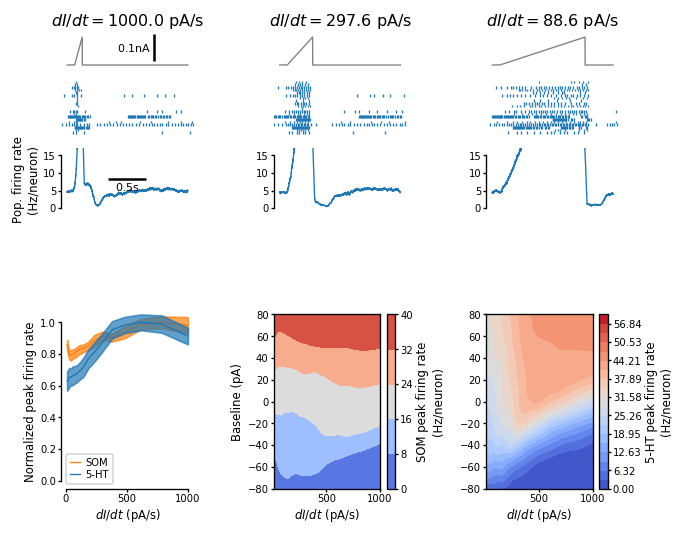

In [20]:
fig = plt.figure(figsize=(6, 5))

spec = gs.GridSpec(2, 3, hspace=0.6, wspace=0.6)

for i, sweep in enumerate(SWEEPS_TO_SHOW):
    ax = plt.subplot(spec[0, i])
    
    trace_spec = gs.GridSpecFromSubplotSpec(3, 3, spec[0, i], height_ratios=[0.5, 1, 1])
    
    plt.subplot(trace_spec[0, :])
    plt.title('$dI/dt = {:.1f}$ pA/s'.format(1e3 * input_arr['metaparams']['deriv_in_nA_s'][sweep]))
    plt.plot(TIME_VEC, input_arr['ser_input'][sweep, 0, TIME_SLICE].T, color=colors['input'])
    if i == 0:
        pltools.add_scalebar(
            y_size=0.1,
            y_units='nA',
            omit_x=True,
            round=False,
            anchor=(0.7, 0.1),
            linewidth=sbarlw
        )
    else:
        pltools.hide_border()
        pltools.hide_ticks()
    
    plt.subplot(trace_spec[1, :])
    plt.eventplot(
        [np.where(sample_trace_model.ser_spktrains[sweep, j, TIME_SLICE])[0] * 0.1 * 1e-3 for j in range(20)],
        color=colors['ser']
    )
    plt.xlim(0, TIME_VEC[-1])
    pltools.hide_ticks()
    pltools.hide_border('a')
    
    plt.subplot(trace_spec[2, :])
    plt.plot(TIME_VEC, sample_trace_psth[sweep, TIME_SLICE].T, color=colors['ser'])
    plt.ylim(-0.5, 17)
    plt.yticks([0, 5, 10, 15])
    if i == 0:
        plt.ylabel('Pop. firing rate\n(Hz/neuron)')
        pltools.add_scalebar(
            x_size=0.5, 
            x_units='s', 
            anchor=(0.7, 0.5), 
            round=False, 
            omit_y=True, 
            remove_frame=False,
            linewidth=sbarlw
        )
    pltools.hide_border('trb', trim=True)



plt.subplot(spec[1, 0])
for i, (label, key) in enumerate(zip(['SOM', '5-HT'], ['som', 'ser'])):
    def normalize(x):
        return x / max_resp[key][5, :].max()
    
    plt.fill_between(
        deriv_in_pA_s,
        normalize(max_resp[key][5, :] - max_resp_std[key][5, :]),
        normalize(max_resp[key][5, :] + max_resp_std[key][5, :]),
        color=colors[key],
        alpha=0.7,
        zorder=i
    )
    plt.plot(
        deriv_in_pA_s, 
        normalize(max_resp[key][5, :]), 
        color=colors[key], 
        label=label,
        zorder=i
    )
plt.legend()
plt.ylim(-0.05, 1.05)
plt.xlabel('$dI/dt$ (pA/s)')
plt.ylabel('Normalized peak firing rate')
pltools.hide_border('tr', trim=True)


som_ax = plt.subplot(spec[1, 1])
som_cbar = fig.colorbar(
    interpolated_contour(
        deriv_in_pA_s, 
        1e3 * BASELINE_LEVELS, 
        max_resp['som'], 
        ax=som_ax,
        levels=np.linspace(0, 40, 6)
    )
)
som_cbar.ax.set_ylabel('SOM peak firing rate\n(Hz/neuron)')
som_ax.set_ylabel('Baseline (pA)')
som_ax.set_xlabel('$dI/dt$ (pA/s)')


raw_ax = plt.subplot(spec[1, 2])
raw_cbar = fig.colorbar(
    interpolated_contour(
        deriv_in_pA_s, 
        1e3 * BASELINE_LEVELS, 
        max_resp['ser'], 
        ax=raw_ax, 
        levels=np.linspace(0, 60, 20)
    )
)
raw_cbar.ax.set_ylabel('5-HT peak firing rate\n(Hz/neuron)')
#raw_ax.set_ylabel('Baseline (pA)')
raw_ax.set_xlabel('$dI/dt$ (pA/s)')

plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'derivative_filter_dv_adaptation_swap_ser_only'))